In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import random
%matplotlib inline

1. Задание:  
    - Сформировать с помощью `sklearn.make_classification` датасет из 1000 объектов с **двумя** признаками.  
    - Обучить случайный лес из 1, 3, 10, 50, 100 и 200 деревьев (за основу взять реализацию построения этого алгоритма из урока).  
    - Визуализировать их разделяющие линии на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции `predict` на `tree_vote`).   
    - Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

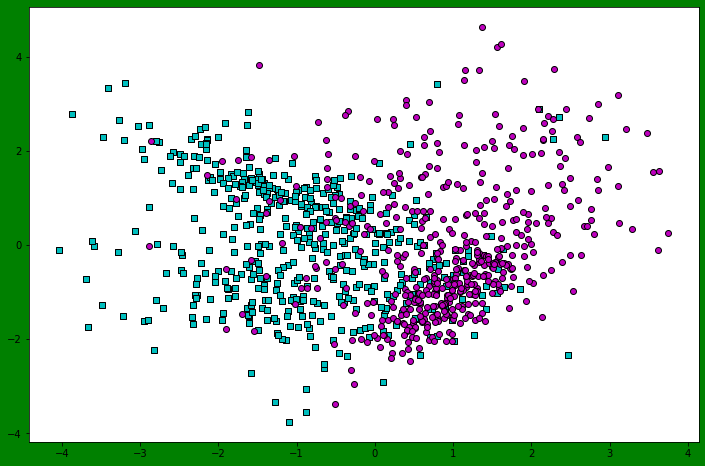

In [2]:
X, y = make_classification(n_samples=1000,
                           n_features=2, n_informative=2,
                           n_classes=2, n_redundant=0,
                           n_clusters_per_class=2, flip_y=.1, random_state=1)
plt.figure(figsize=(12, 8), facecolor='g')

# colors = ListedColormap(['c', 'm'])
# plt.scatter([x[0] for x in X], [x[1] for x in X], marker="s", edgecolor='k', c=y, cmap=colors)

# plt.scatter([x[0] for x in X[y == 0]], [x[1] for x in X[y == 0]], marker="s", edgecolor="k", c="c")
# plt.scatter([x[0] for x in X[y == 1]], [x[1] for x in X[y == 1]], marker="o", edgecolor="k", c="m")

plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], marker="s", edgecolor="k", c="c")
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], marker="o", edgecolor="k", c="m")
plt.show()

In [3]:
class my_DecisionTreeClassifier:
    
    def __init__(self, criterion="gini", min_samples_leaf=1, max_leaf_nodes=None):
        self.criterion = criterion
        self.min_samples_leaf = min_samples_leaf
        self.max_leaf_nodes = max_leaf_nodes
        
    def fit(self, data, labels, max_depth=None, subset_feats_flag=False):
        self.max_depth = max_depth
        quality, t, index = Node.find_best_split(self, data, labels, subset_feats_flag)
        if (t is None) or (index is None):
            return Leaf(data, labels)
        true_data, false_data, true_labels, false_labels = Node.split(data, labels, index, t)
        if (len(true_data) <= self.min_samples_leaf) or (len(false_data) <= self.min_samples_leaf):
            return Leaf(data, labels)
        if max_depth is not None:
            if max_depth != 0:
                max_d = max_depth - 1
                true_branch = my_DecisionTreeClassifier.fit(self, true_data, true_labels, 
                                                            max_depth=max_d)
                false_branch = my_DecisionTreeClassifier.fit(self, false_data, false_labels, 
                                                             max_depth=max_d)
            else:
                return Leaf(data, labels)
        else:
            true_branch = my_DecisionTreeClassifier.fit(self, true_data, true_labels)
            false_branch = my_DecisionTreeClassifier.fit(self, false_data, false_labels)
        self.dtree = Node(index, t, true_branch, false_branch)
        return self.dtree
    
    @staticmethod
    def classify_obj(obj, node):
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer
        if obj[node.index] <= node.t:
            return my_DecisionTreeClassifier.classify_obj(obj, node.true_branch)
        else:
            return my_DecisionTreeClassifier.classify_obj(obj, node.false_branch)
    
    def labels_predict(self, X, tree=None):
        if tree == None:
            tree = self.dtree
        pred_vec = []
        for obj in X:
            pred_val = my_DecisionTreeClassifier.classify_obj(obj, tree)
            pred_vec.append(pred_val)
        return pred_vec
    
######    
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
    def predict(self):
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0 
            classes[label] += 1
        prediction = max(classes, key=classes.get)
        return prediction
    
######    
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

    @staticmethod
    def gini(labels):
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2
        return impurity
    
    @staticmethod
    def entropy(labels):
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        entropy_index = 0
        for label in classes:
            p = classes[label] / len(labels)
            entropy_index -= 0 if p == 0 else p*np.log2(p)
        return entropy_index

    @staticmethod
    def quality(left_labels, right_labels, criterion, current_criteria):
        weig = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        if criterion == 'gini':
            return current_criteria - weig * Node.gini(left_labels) \
                                                                - (1 - weig) * Node.gini(right_labels)
        elif criterion == 'entropy':
            return current_criteria - weig * Node.entropy(left_labels) \
                                                                - (1 - weig) * Node.entropy(right_labels)
    
    @staticmethod
    def split(data, labels, index, t):
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)
        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]
        return true_data, false_data, true_labels, false_labels
    
    def find_best_split(self, data, labels, subset_feats_flag=False):
        if self.criterion == 'gini':
            current_criteria = Node.gini(labels)
        elif self.criterion == 'entropy':
            current_criteria = Node.entropy(labels)
        best_quality = 0
        best_t = None
        best_index = None
        k = (int(np.sqrt(data.shape[1])) if subset_feats_flag else data.shape[1])
        for index in random.sample(range(data.shape[1]), k=k):
            t_values = np.unique([row[index] for row in data])
            for t in t_values:
                true_data, false_data, true_labels, false_labels = Node.split(data, labels, index, t)
                if len(true_data) < self.min_samples_leaf or len(false_data) < self.min_samples_leaf:
                    continue
                current_quality = Node.quality(true_labels, false_labels, 
                                               self.criterion, current_criteria)
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index
        return best_quality, best_t, best_index

    @staticmethod
    def accuracy_metric(actual, predicted):
        correct = 0
        for i in range(len(actual)):
            if actual[i] == predicted[i]:
                correct += 1
        return correct / float(len(actual))

In [4]:
class my_RandomForestClassifier(my_DecisionTreeClassifier):
    
    def __init__(self, n_trees=10):
        self.n_trees = n_trees

    def get_bootstrap(self, X, y, N=None):
        if N is None: N = self.n_trees
        random.seed(29)
        n_samples = X.shape[0]
        bootstrap_set = []
        for _ in range(N):
            indices = random.choices(range(n_samples), k=n_samples)
            bootstrap_set.append((X[indices], y[indices]))
        return bootstrap_set
    
    def oob_bootstrap(self, X, y, N=None):
        if N is None: N = self.n_trees
        random.seed(29)
        n_samples = X.shape[0]
        bootstrap_set = []
        oob_set = []
        oob_inv_ind = []
        for _ in range(N):
            indices = random.choices(range(n_samples), k=n_samples)
            inv_indices = [val for val in range(n_samples) if not val in set(indices)]
            oob_set.append((X[inv_indices], y[inv_indices]))
            oob_inv_ind.append(inv_indices)
            bootstrap_set.append((X[indices], y[indices]))
        self.oob_inv_ind = oob_inv_ind
        self.oob_set = oob_set
        return bootstrap_set
    
    """данный метод не потребовался; я внес изменения в надкласс my_DecisionTreeClassifier, 
       а конкретно в метод find_best_split();"""
    #     @staticmethod
    #     def get_feats_subset(num_feats):
    #         num_subfeats = int(np.sqrt(num_feats))
    #         subfeat_inds = random.sample(range(num_feats), k=num_subfeats)
    #         return subfeat_inds
    
    def randomforest_build(self, X, y, n_trees=None):
        if n_trees is None: n_trees = self.n_trees
        forest = []
        bs_set = my_RandomForestClassifier.oob_bootstrap(self, X, y, n_trees)
        for bs_X, bs_y in bs_set:
            cls = my_DecisionTreeClassifier()
            forest.append(cls.fit(bs_X, bs_y, subset_feats_flag=True))
        return forest
    
    def tree_vote(self, forest, data):
        pred = []
        for tree in forest:
            pred.append(my_DecisionTreeClassifier.labels_predict(self, data, tree))
        pred_per_obj = list(zip(*pred))
        voted_pred = []
        for obj in pred_per_obj:
            voted_pred.append(max(obj, key=obj.count))
        return voted_pred
    
    def oob_vote(self, forest):
        oob_pred = []
        oob_set = self.oob_set
        oob_inv_ind = self.oob_inv_ind
        for num, tree in enumerate(forest):
            oob_pred.append(my_DecisionTreeClassifier.labels_predict(self, oob_set[num][0], tree))
        oob_dict_pred = {}
        oob_dict_actu = {}
        for pos, p in enumerate(oob_pred):
            for num, val in enumerate(p):
                if oob_inv_ind[pos][num] not in oob_dict_pred:
                    oob_dict_pred[oob_inv_ind[pos][num]] = [val]
                    oob_dict_actu[oob_inv_ind[pos][num]] = oob_set[pos][1][num]
                else:
                    oob_dict_pred[oob_inv_ind[pos][num]].append(val)
                    # oob_dict_actu[oob_inv_ind[pos][num]] = oob_set[pos][1][num] # похоже эта строка лишняя
        for k, v in oob_dict_pred.items():
            oob_dict_pred[k] = max(v, key=v.count)
        oob_pred_list = list(oob_dict_pred.values())
        oob_actu_list = list(oob_dict_actu.values())
        return oob_actu_list, oob_pred_list  # oob_dict_pred, oob_dict_actu

In [5]:
train_feats, test_feats, train_labels, test_labels = train_test_split(X, y, test_size=.3, random_state=29)

In [6]:
n_trees_list = [1, 3, 10, 50, 100, 200]
res = []
for num in n_trees_list:
    rf_cls = my_RandomForestClassifier(num)
    forest_ = rf_cls.randomforest_build(train_feats, train_labels)
    train_pred = rf_cls.tree_vote(forest_, train_feats)
    train_metric = Node.accuracy_metric(train_labels, train_pred)
    print(f"метрика на traine:\t{train_metric:.4f}")
    test_pred = rf_cls.tree_vote(forest_, test_feats)
    test_metric = Node.accuracy_metric(test_labels, test_pred)
    print(f"метрика на teste:\t{test_metric:.4f}\n")
    res.append((train_metric, test_metric))

метрика на traine:	0.8757
метрика на teste:	0.7667

метрика на traine:	0.8914
метрика на teste:	0.8000

метрика на traine:	0.8957
метрика на teste:	0.8000

метрика на traine:	0.8957
метрика на teste:	0.8100

метрика на traine:	0.8943
метрика на teste:	0.8067

метрика на traine:	0.8929
метрика на teste:	0.8033



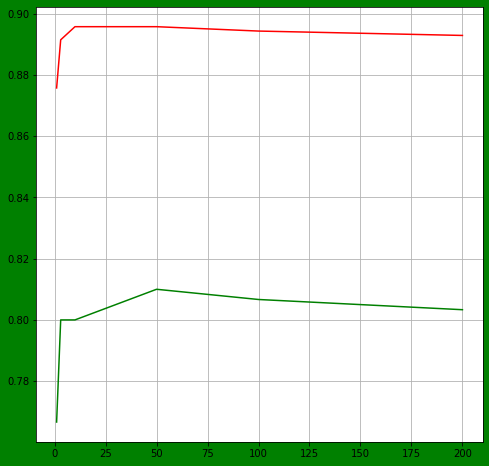

In [7]:
plt.figure(figsize=(8,8), facecolor="g")
plt.plot(n_trees_list, [metric[0] for metric in res], c="r")
plt.plot(n_trees_list, [metric[1] for metric in res], c="g")
plt.grid()
plt.show()

In [8]:
def get_meshgrid(arr, step=.05, border=1):
    x0 = np.arange(arr[:,0].min() - border, arr[:,0].max() + border, step=step)
    x1 = np.arange(arr[:,1].min() - border, arr[:,1].max() + border, step=step)
    return np.meshgrid(x0, [*reversed(x1)]) # x1) 

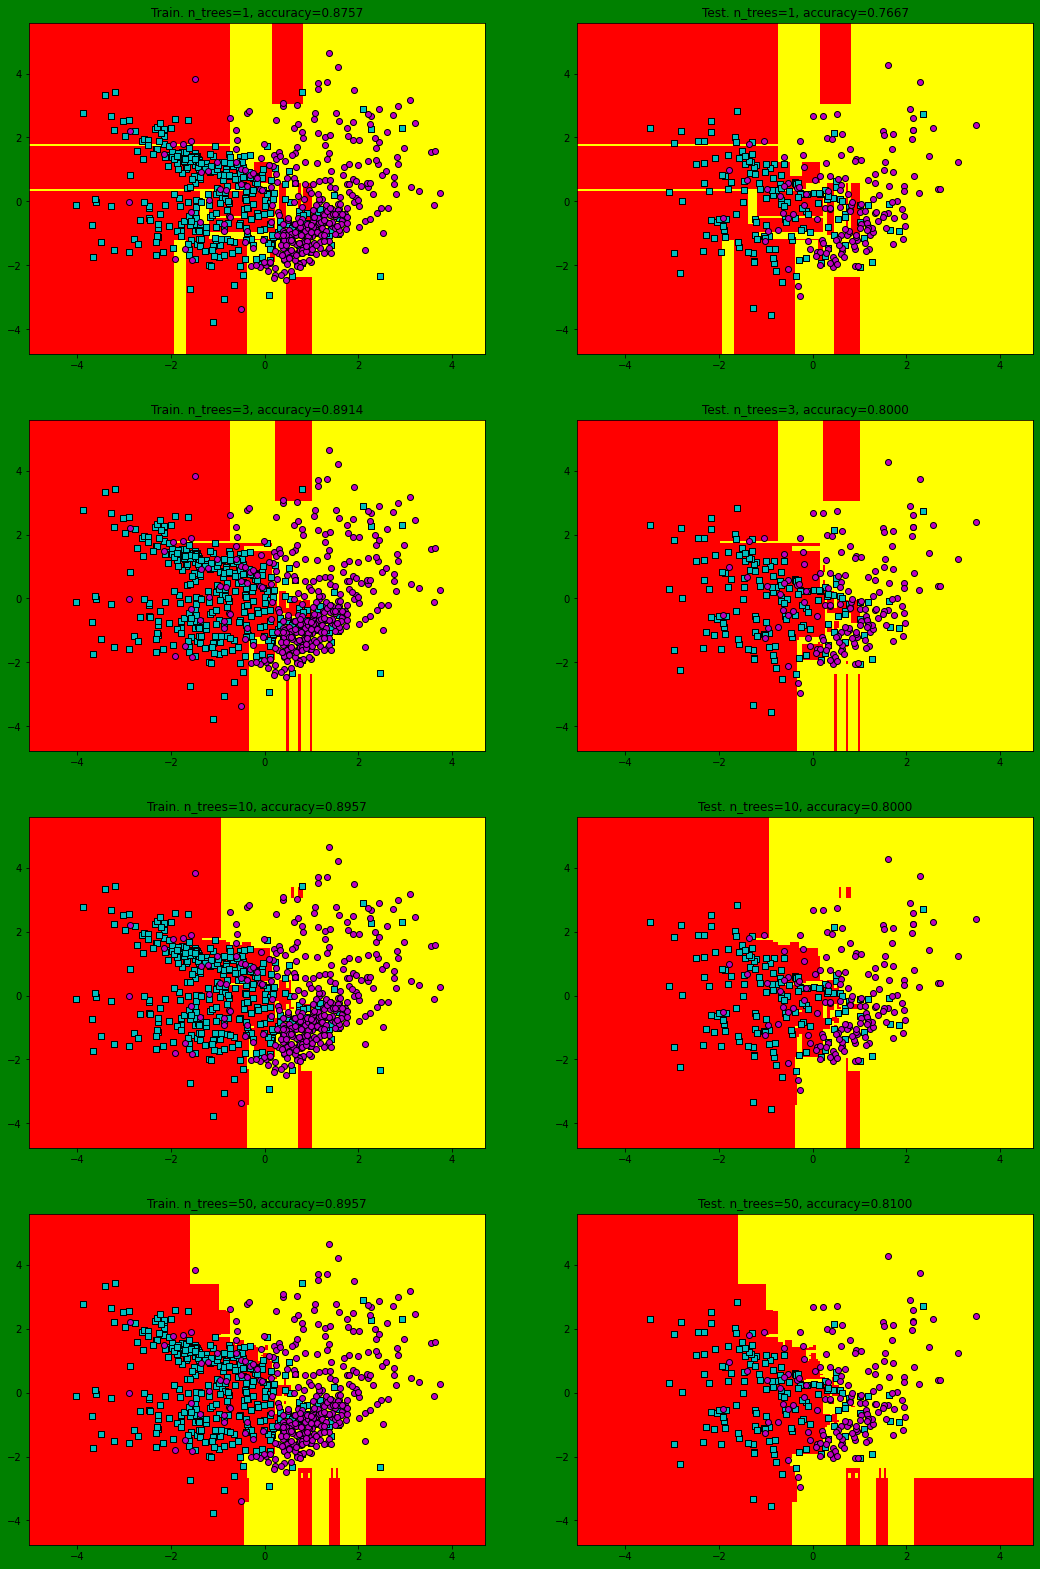

In [9]:
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings("ignore")
user_colormap = ListedColormap(["lightcoral", "lightblue"])

plt.figure(figsize=(18,28), facecolor="g")

i = 1
for n_trees in n_trees_list[:4]:
    rf_cls2 = my_RandomForestClassifier(n_trees)
    randforest_2 = rf_cls2.randomforest_build(train_feats, train_labels)

    mg = get_meshgrid(train_feats)
    mg_pred = np.array(rf_cls2.tree_vote(randforest_2, np.c_[np.ravel(mg[0]), 
                                                             np.ravel(mg[1])])).reshape(mg[0].shape)

    accr_train = Node.accuracy_metric(train_labels, rf_cls2.tree_vote(randforest_2, train_feats))
    accr_test = Node.accuracy_metric(test_labels, rf_cls2.tree_vote(randforest_2, test_feats))

    a = 420 + 2*i - 1
    plt.subplot(a)
    plt.pcolormesh(mg[0], mg[1], mg_pred, cmap="autumn") # cmap=user_colormap
    plt.scatter(train_feats[:,0][train_labels == 0], 
                train_feats[:,1][train_labels == 0], 
                c="c", marker="s", edgecolor="k")
    plt.scatter(train_feats[:,0][train_labels == 1], 
                train_feats[:,1][train_labels == 1], 
                c="m", marker="o", edgecolor="k")
    plt.title(f"Train. n_trees={n_trees}, accuracy={accr_train:.4f}")

    plt.subplot(a+1)
    plt.pcolormesh(mg[0], mg[1], mg_pred, cmap="autumn") # cmap=user_colormap
    plt.scatter(test_feats[:,0][test_labels == 0], 
                test_feats[:,1][test_labels == 0], 
                c="c", marker="s", edgecolor="k")
    plt.scatter(test_feats[:,0][test_labels == 1], 
                test_feats[:,1][test_labels == 1], 
                c="m", marker="o", edgecolor="k")
    plt.title(f"Test. n_trees={n_trees}, accuracy={accr_test:.4f}")
    i += 1

plt.show()

##### Какие выводы можно сделать.
Во-первых, Random Forest, как и Decision Trees на которых они основаны, явно нелинейный алгоримт. Построить адекватную разделяющую гиперплоскость с помощью логистической регрессии на таких данных было бы намного труднее. Во всяком случае метрики были бы намного ниже. Другими словами разделяющая гиперплоскость, которую построили Случайные Леса намного сложнее, чем в случае логистической регрессии.

Что касается этой модели. Результаты в зависимости от количества деревьев в лесе не сильно отличаются. Это заметно по метрикам, которые довольно стабильны и по графикам, которые отличаются главным образом областями в которых нет данных.

Качество на тесте не падает, поэтому заявить о переобучении на этих результатах очень трудно.

Что еще мне показалось интересным - модель Случайного Леса гонится за выбросами. Возможно если на предварительном этапе подготовки данных для анализа избавиться от выбросов, то может быть получилось бы улучшить метрики модели.

#### 2. (\*) Задание:

Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

Оба данных метода `oob_bootstrap`, `oob_vote` я перенес в ячейку с классом `my_RandomForestClassifier`

#### Проверяем работу методов сделанных для второго задания:

In [14]:
rf_cls3 = my_RandomForestClassifier(10)
randforest3 = rf_cls3.randomforest_build(X, y)
# rf_cls3.oob_bootstrap(X, y, 10)

In [15]:
actual, prediction = my_RandomForestClassifier.oob_vote(rf_cls3, randforest3)

In [19]:
print(f"{Node.accuracy_metric(actual, prediction):.6f}")

0.807887


Вуаля, все работает.

Остался один вопрос касательно этой части:

>$$OOB = \sum^{l}_{i=1}L\left ( y_{i}, \:\frac{1}{\sum^{N}_{n=1}[x_{i}\notin X_{n}]} \sum^{N}_{n=1}[x_{i} \notin X_{n}]b_{n}(x_{i}) \right ).$$

>Здесь $L(y, z)$ - функция потерь, а выражение в скобках и представляет из себя среднюю ошибку на объекте $x_{i}$ среди деревьев, которые на нем не обучались.

Вопрос здесь что такое функция потерь $L(y, z)$ в данном случае, то есть вот какая у нее конкретная формула?

Формула с сигмоидой как в логистической регрессии? не похоже ... где взять отступ, непрерывное значение, которое мы превращаем в вероятность - у нас ничего такого нет? Вроде не подходит, мы сразу имеем дело с метками_классов. Энтропия Шеннона, критерий Gini тоже нет, это другое...

Что же здесь имеется в виду? Я не совсем понял. Или просто написали в общем, для разных алгоритмов? Не могу сложить общей картины. Что то я затупил на этом месте(((

Я же сделал определение класса голосованием результатов нескольких деревьев. Правда мне не понравилось, что при равном количестве меток функция `max(list, key=count)` выдает то ноль, то единицу (в зависимости от того что стоит на первом месте).